<a href="https://colab.research.google.com/github/ShasmaAfs/RAG-School-Certificate/blob/main/School_certificate_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Install a supported numpy version for Chroma
!pip install numpy==1.26.4 --force-reinstall --no-cache-dir

# 2. Install ChromaDB (compatible version)
!pip install chromadb==0.4.22

# 3. Install remaining libraries (these do not conflict)
!pip install sentence-transformers pdfplumber pytesseract transformers accelerate safetensors pillow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 250.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have n

In [2]:
from google.colab import files

uploaded = files.upload()
file_name = list(uploaded.keys())[0]

print("Uploaded:", file_name)


Saving school.png to school.png
Uploaded: school.png


In [3]:
import pdfplumber
from PIL import Image
import pytesseract

extracted_text = ""

if file_name.lower().endswith(".pdf"):
    with pdfplumber.open(file_name) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text() or ""
            extracted_text += page_text + "\n"
else:
    img = Image.open(file_name)
    extracted_text = pytesseract.image_to_string(img)

print("Extracted Text:\n")
print(extracted_text)


Extracted Text:

IJIULTIVWVUVL

CERTIFICATE

Student Name:
Siyasath Shasma
School:

Mahmud Ladies College
Year:

2019
Subjects: Chemistry, Physics, Maths

Issued by:
Ministry of Education



In [4]:
import chromadb
from chromadb.utils import embedding_functions

embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

chroma_client = chromadb.Client()

collection = chroma_client.create_collection(
    name="school_certificate_rag",
    embedding_function=embedding_function
)

collection.add(
    documents=[extracted_text],
    ids=["school_certificate"]
)

print("Vector DB ready!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionAddEvent: capture() takes 1 positional argument but 3 were given


Vector DB ready!


In [5]:
from transformers import pipeline

# QA model
qa_model = pipeline("question-answering", model="deepset/roberta-base-squad2")

def rag_query(question: str) -> str:
    # 1. Retrieve most relevant document chunk
    results = collection.query(
        query_texts=[question],
        n_results=1
    )
    context = results["documents"][0][0]

    # 2. Use QA model on that context
    answer = qa_model({
        "question": question,
        "context": context
    })

    return answer["answer"]


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cpu


In [7]:
print("Name   :", rag_query("What is the student's name?"))

Name   : Siyasath Shasma


In [8]:
print("School :", rag_query("What is the school name?"))

School : Mahmud Ladies College


In [9]:
print("Year   :", rag_query("What is the year?"))

Year   : 2019


In [10]:
print("Subjects:", rag_query("What are the subjects?"))

Subjects: Chemistry, Physics, Maths


In [11]:
print("Issued by:", rag_query("Who issued it?"))

Issued by: 
Ministry of Education



In [20]:
!apt-get install -y fonts-dejavu-core


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-dejavu-core
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,041 kB of archives.
After this operation, 3,025 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Fetched 1,041 kB in 1s (1,140 kB/s)
Selecting previously unselected package fonts-dejavu-core.
(Reading database ... 121703 files and directories currently installed.)
Preparing to unpack .../fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [21]:
!ls /usr/share/fonts/truetype/dejavu


DejaVuSans-Bold.ttf	 DejaVuSansMono.ttf  DejaVuSerif-Bold.ttf
DejaVuSansMono-Bold.ttf  DejaVuSans.ttf      DejaVuSerif.ttf


In [28]:
from PIL import Image, ImageDraw, ImageFont
import math

def generate_upgraded_school_badge(initials="MLCK"):
    # Canvas size
    size = 650
    img = Image.new("RGBA", (size, size), (255, 255, 255, 0))
    draw = ImageDraw.Draw(img)

    # Colors
    blue   = (25, 60, 200)
    green  = (0, 160, 80)
    yellow = (240, 200, 20)
    gold   = (212, 175, 55)

    # Outer golden ring
    draw.ellipse((0, 0, size, size), fill=gold)

    # Outer blue circle
    padding = 20
    draw.ellipse((padding, padding, size-padding, size-padding), fill=blue)

    # Middle green circle
    padding2 = 70
    draw.ellipse((padding2, padding2, size-padding2, size-padding2), fill=green)

    # Inner yellow circle
    padding3 = 130
    draw.ellipse((padding3, padding3, size-padding3, size-padding3), fill=yellow)

    # Fonts
    big_font  = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 90)
    star_font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 60)

    # ================================
    #  CENTER TEXT: MLCK
    # ================================
    text = initials.upper()
    bbox = draw.textbbox((0, 0), text, font=big_font)
    tw = bbox[2] - bbox[0]
    th = bbox[3] - bbox[1]

    cx = (size - tw) // 2
    cy = (size - th) // 2
    draw.text((cx, cy), text, fill="black", font=big_font)

    # ================================
    #  DRAW 5 STARS AROUND INNER CIRCLE
    # ================================
    star = "★"
    star_radius = 220  # distance from center
    center = size // 2

    for i in range(5):
        angle = math.radians(90 + i * 72)  # 5 stars, 360/5 = 72 degrees apart
        x = center + star_radius * math.cos(angle)
        y = center + star_radius * math.sin(angle)

        # Center the star around (x,y)
        sbbox = draw.textbbox((0, 0), star, font=star_font)
        sw = sbbox[2] - sbbox[0]
        sh = sbbox[3] - sbbox[1]

        draw.text((x - sw/2, y - sh/2), star, fill="white", font=star_font)

    # Save badge
    path = "/content/school_badge_upgraded.png"
    img.save(path)

    return path


In [29]:
badge_path = generate_upgraded_school_badge("MLCK")
print("Badge saved at:", badge_path)


Badge saved at: /content/school_badge_upgraded.png


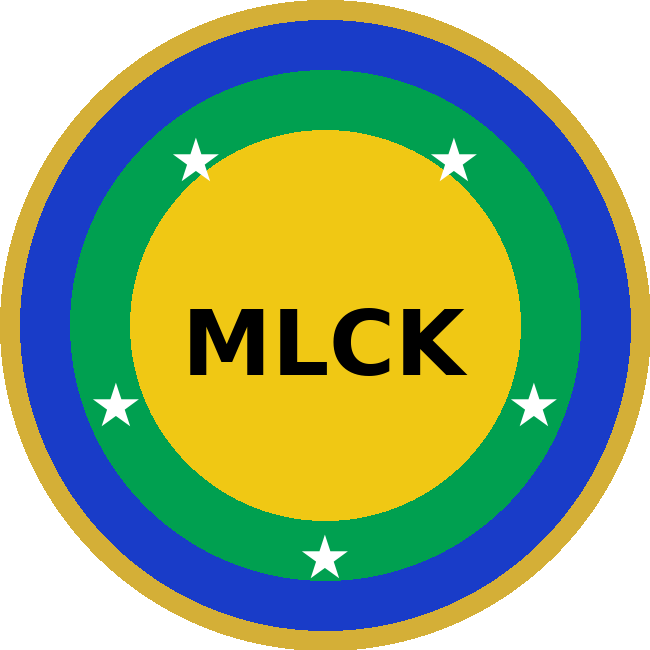

In [30]:
from IPython.display import Image
Image(filename=badge_path)
